# Context 

Model selection and final forecasting

- Build a DataFrame containing the last five years of historical data for both training and evaluation.
- Perform model selection to identify the best-performing approach.
- Generate the final out‐of‐sample forecast using the selected model.

# Import

In [0]:
%pip install prophet
%pip install tensorflow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StructType, StructField, DateType, DoubleType
from pyspark.sql.functions import (
    col, to_date, lag, avg, stddev, log, when, current_date,
    date_sub, add_months, expr, row_number, dayofweek, lit,
    pandas_udf, PandasUDFType
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from prophet import Prophet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
spark = SparkSession.builder.appName("AAPL_Prediction").getOrCreate()

From the dataset we decided to keep only the last 5 years just for test purposes

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

# Models Selection


- in order to test the models we decided only to use a 5 year window 
- For all the model we are using a 30 days test window, this does not mean that the models will make a prediction for each day as the weekends are not taken into our data

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

original_df = spark_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
num_rows = original_df.count()
num_cols = len(original_df.columns)
print(num_rows, num_cols)
original_df.printSchema()

# take only the last 5 years to reduce the amount of data (just for testing)
cutt_point = -60
cutoff = add_months(current_date(), cutt_point)
df_cutt = original_df.filter(col("date") >= cutoff)


df_cutt = df_cutt.cache()
print(f"Filtered (last 5y): {df_cutt.count()} rows")
df_cutt.show(5, truncate=False)

ts_df = df_cutt

5029 6
root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)

Filtered (last 5y): 1257 rows
+----------+------+------+------+------+--------+
|date      |open  |high  |low   |close |volume  |
+----------+------+------+------+------+--------+
|2020-05-18|313.17|316.5 |310.32|314.96|33843125|
|2020-05-19|315.03|318.52|313.01|313.14|25432385|
|2020-05-20|316.68|319.52|316.52|319.23|27876215|
|2020-05-21|318.66|320.89|315.87|316.85|25672211|
|2020-05-22|315.77|319.23|315.35|318.89|20450754|
+----------+------+------+------+------+--------+
only showing top 5 rows



In [0]:
# create dates for that will be used for testing 
all_dates = [r.date for r in ts_df.select("date").distinct().orderBy("date").collect()]
test_dates = all_dates[-30:]
ts_df = ts_df.select("date", "close")

## Auxilarry Functions 

we decidd to create some feature but we decided to use only features that would be availble at the time of the prediction
- because we are only predicting "close" we decided not to use the coulmns "open" and "volume" because although we have the data for in order to test our algorithms the data won't be available for actual prediction

In [0]:
def make_features(df):
    w = Window.orderBy("date")
    w_roll5 = Window.orderBy("date").rowsBetween(-5, -1)
    w_roll30 = Window.orderBy("date").rowsBetween(-30, -1)
    return (
        df
        .withColumn("close_lag1",lag("close", 1).over(w))
        .withColumn("close_lag2",lag("close", 2).over(w))
        .withColumn("close_lag3",lag("close", 3).over(w))
        .withColumn("close_lag4",lag("close", 4).over(w))
        .withColumn("close_lag5",lag("close", 5).over(w))
        .withColumn("ma5",avg("close").over(w_roll5))
        .withColumn("ma30",avg("close").over(w_roll30))
        .withColumn("dow",dayofweek("date"))
        .na.drop()
    )

## Model using GBTR

we first create:
- the feature in order to see how would our model me fitted only on train data 
- a set of dates that would be used for testing 
- a vector assemble that would be used in the pipeline

In [0]:
# create a vector for the feature that are going to be used for this model
assembler = VectorAssembler(
    inputCols=["close_lag1","close_lag2","close_lag3","close_lag4","close_lag4","close_lag5","ma5","ma30","dow"],
    outputCol="features"
)
gbt = GBTRegressor(labelCol="close", featuresCol="features", maxIter=50)


### Model Run

we first run the model on the overall train_data to see how it fits

Train RMSE = 10.1773
Train Relative RMSE  = 0.0562


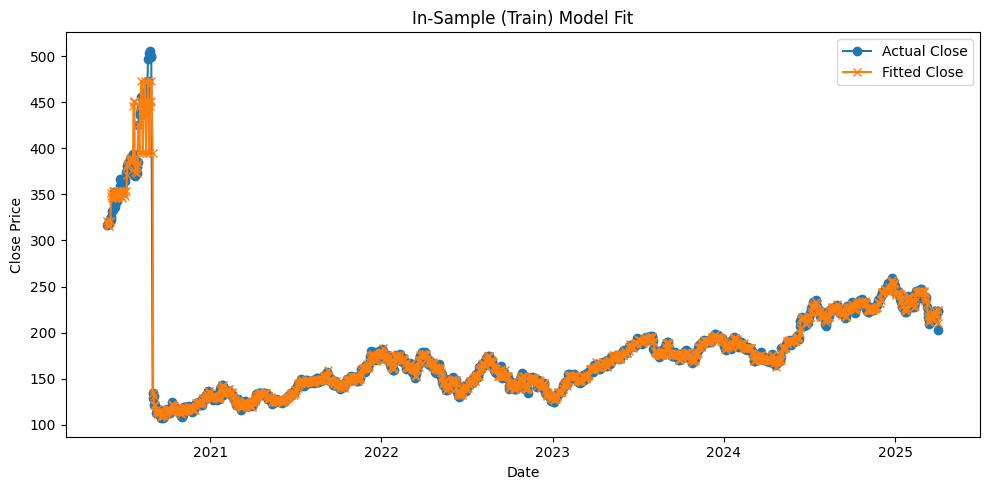

In [0]:
feat_df = make_features(ts_df)
train_feat_df = feat_df.filter(~col("date").isin(test_dates))
train_vec = assembler.transform(train_feat_df)
model = gbt.fit(train_vec)

preds_train = (
    model
      .transform(train_vec)
      .select(
          col("date"),
          col("prediction"),
          col("close").alias("actual")
      )
)

evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
train_rmse = evaluator.evaluate(preds_train)
mean_actual = preds_train.select(avg("actual")).first()[0]
train_rrmse = train_rmse / mean_actual

print(f"Train RMSE = {train_rmse:.4f}")
print(f"Train Relative RMSE  = {train_rrmse:.4f}")

train_pdf = preds_train.toPandas()
train_pdf["date"] = pd.to_datetime(train_pdf["date"])

plt.figure(figsize=(10,5))
plt.plot(train_pdf["date"], train_pdf["actual"],     marker='o', label="Actual Close")
plt.plot(train_pdf["date"], train_pdf["prediction"], marker='x', label="Fitted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("In-Sample (Train) Model Fit")
plt.legend()
plt.tight_layout()
plt.show()

In our evaluation we use a **rolling, one-day-ahead** forecasting strategy:

1. **Train on historical data up to the forecast date**  
   At each step, we fit the model on all available data **before** the day we want to predict. This mimics how you would train in production—only past information is ever used.

2. **Predict the next day’s close price**  
   We generate a single forecast for “tomorrow” (the next trading day) using that freshly trained model.

3. **Feed the prediction back in**  
   Instead of using the true close for the next step (which would leak future information), we inject our own forecast into the historical series. Those forecasts then become part of the training data for the following day’s model fit.

This procedure guarantees that **no future actual prices** are ever used when making each prediction—exactly as would occur in a real-world deployment. It also means we can only compute performance metrics (RMSE, RRMSE, etc.) **once** the true values are eventually observed (e.g. end-of-day actual closes).

Done 2025-04-04: pred=212.4742, actual=188.3800
Done 2025-04-07: pred=222.6344, actual=181.4600
Done 2025-04-08: pred=225.5881, actual=172.4200
Done 2025-04-09: pred=224.3414, actual=198.8500
Done 2025-04-10: pred=221.2487, actual=190.4200
Done 2025-04-11: pred=224.6480, actual=198.1500
Done 2025-04-14: pred=225.1811, actual=202.5200
Done 2025-04-15: pred=225.3260, actual=202.1400
Done 2025-04-16: pred=214.0412, actual=194.2700
Done 2025-04-17: pred=217.8526, actual=196.9800
Done 2025-04-21: pred=219.6621, actual=193.1600
Done 2025-04-22: pred=219.5883, actual=199.7400
Done 2025-04-23: pred=219.2744, actual=204.6000
Done 2025-04-24: pred=216.6621, actual=208.3700
Done 2025-04-25: pred=216.9129, actual=209.2800


Done 2025-04-28: pred=218.2584, actual=210.1400
Done 2025-04-29: pred=218.9065, actual=211.2100


Done 2025-04-30: pred=218.9286, actual=212.5000
Done 2025-05-01: pred=218.2128, actual=213.3200
Done 2025-05-02: pred=217.3555, actual=205.3500
Done 2025-05-05: pred=218.7894, actual=198.8900
Done 2025-05-06: pred=218.5199, actual=198.5100
Done 2025-05-07: pred=218.5374, actual=196.2500
Done 2025-05-08: pred=217.4318, actual=197.4900
Done 2025-05-09: pred=218.2428, actual=198.5300
Done 2025-05-12: pred=218.5367, actual=210.7900
Done 2025-05-13: pred=218.7313, actual=212.9300
Done 2025-05-14: pred=218.3775, actual=212.3300
Done 2025-05-15: pred=218.1546, actual=211.4500
Done 2025-05-16: pred=217.9361, actual=211.2600
Test RMSE = 21.0991
Test Relative RMSE = 0.1048)


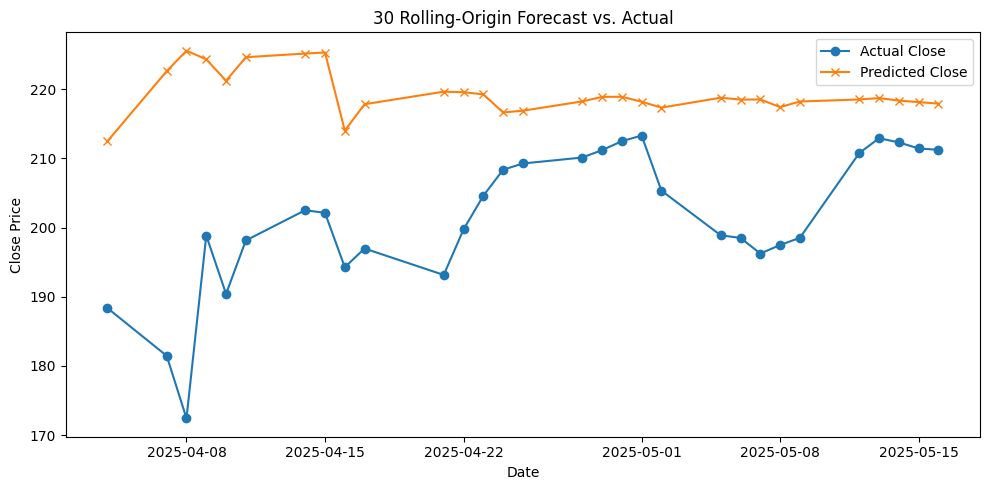

In [0]:
history = ts_df.filter(~col("date").isin(test_dates))
results = []

# for everyday that we want to predict
for d in test_dates:
    # create a fake row with 0 as value in orter to be able to create the lags and then put them at the level of the prediction 
    dummy_row = spark.createDataFrame([Row(date=d, close=0.0)])
    ext_history = history.union(dummy_row)

    # compute all lags & moving‐averages up through date d (never peeking ahead)
    feat_df = make_features(ext_history)

    # build the vectors for both train and test
    train_vec = assembler.transform(feat_df.filter(col("date") < d))
    test_vec  = assembler.transform(feat_df.filter(col("date") == d))

    # fit the model on everything before d, then predict for d
    model = gbt.fit(train_vec)
    pred  = model.transform(test_vec).select("prediction").first()[0]

    # Grab the true value, record the result, and then “commit” our prediction
    actual = ts_df.filter(col("date") == d).select("close").first()[0]
    results.append((d, float(pred), float(actual)))

    # add the predicted close back into history for the next date’s features
    history = history.union(spark.createDataFrame([Row(date=d, close=float(pred))]))

    print(f"{d} → predicted {pred:.4f}, actual {actual:.4f}")

evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="predicted",
    metricName="rmse"
)
# create a spark dataframe from the result and calculate the RMSE using it and RRMSE
result_df = spark.createDataFrame(results, ["date", "predicted", "actual"])
rmse = evaluator.evaluate(result_df)
mean_actual = result_df.select(avg("actual")).first()[0]
rel_rmse = rmse / mean_actual

print(f"Test RMSE = {rmse:.4f}")
print(f"Test Relative RMSE = {rel_rmse:.4f})")

# plot the results
pdf = result_df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf["date"], pdf["actual"], marker='o', label="Actual Close")
plt.plot(pdf["date"], pdf["predicted"], marker='x', label="Predicted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("30 Rolling-Origin Forecast vs. Actual")
plt.legend()
plt.tight_layout()
plt.show()


Based on these results, the model tends to persistently predict high values. This occurs because of the rolling‐prediction setup: once it forecasts a high value, that prediction becomes the input for the next step, leading to a chain of high forecasts.

On the **training set**, the model fits well since it uses the *actual* closing price at each step, allowing it to self-correct. During **testing**, however, it relies solely on its *own* previous predictions, so it cannot correct errors in real time and consequently drifts upward.


## Model using Prophet (pandas UDFs)




We use the same workflow as before but train Prophet on the target series alone.  
Since Prophet isn’t built into Spark, we leverage a pandas UDF to fit and predict:

- **Fit** the model on the training set and generate out-of-sample forecasts to evaluate performance.
- **Note:** We attempted a rolling-window approach to include our engineered features, but couldn’t avoid leakage—feature calculations were unintentionally using future actuals. To keep the evaluation clean, we focus here on univariate forecasting with Prophet.



/databricks/spark/python/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


train RMSE = 30.5899
train Relative RMSE = 0.1685


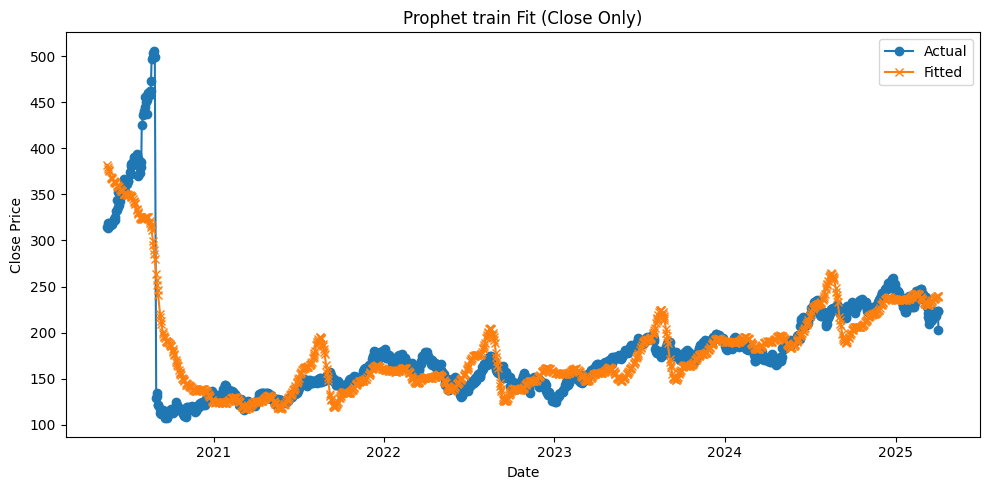

In [0]:
schema_train_ = StructType([
    StructField("date", DateType()),
    StructField("prediction", DoubleType()),
    StructField("actual",DoubleType())
])

# pandas UDF: fit Prophet on full training set, predict on that same set
@pandas_udf(schema_train_, PandasUDFType.GROUPED_MAP)
def prophet_train_ample(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.sort_values("date")
    pdf["ds"] = pd.to_datetime(pdf["date"])
    pdf["y"]  = pdf["close"]
    
    m = Prophet()
    m.fit(pdf[["ds","y"]])
    
    # predict in‐sample
    fc = m.predict(pdf[["ds"]])  # returns ds, yhat, etc.
    return pd.DataFrame({ "date": fc["ds"].dt.date, "prediction": fc["yhat"], "actual": pdf["y"].values})

# Apply UDF to all rows *except* the test dates
train_df = ts_df.filter(~col("date").isin(test_dates)).withColumn("grp", lit(1))
train_preds = train_df.groupBy("grp").apply(prophet_train_ample).drop("grp")

 # calculate the errors
evaluator = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
train_rmse = evaluator.evaluate(train_preds)
mean_train_act = train_preds.select(avg("actual")).first()[0]
train_rrmse = train_rmse / mean_train_act

print(f"train RMSE = {train_rmse:.4f}")
print(f"train Relative RMSE = {train_rrmse:.4f}")

pdf_train_ = train_preds.toPandas()
pdf_train_["date"] = pd.to_datetime(pdf_train_["date"])

plt.figure(figsize=(10,5))
plt.plot(pdf_train_["date"], pdf_train_["actual"],    marker='o', label="Actual")
plt.plot(pdf_train_["date"], pdf_train_["prediction"],marker='x', label="Fitted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Prophet train Fit (Close Only)")
plt.legend()
plt.tight_layout()
plt.show()

We make the prediction on our test set in order to evaluate how our model would perform in "real-life" seneario

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Direct RMSE = 41.8793
Direct Relative RMSE = 0.2080


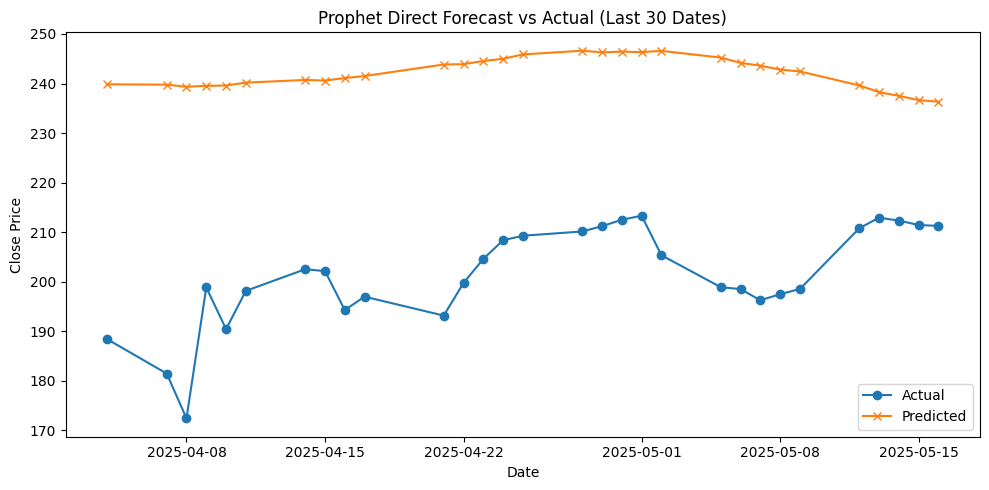

In [0]:
# define output schema
schema_out = StructType([
    StructField("date", DateType()),
    StructField("prediction", DoubleType()),
    StructField("actual",DoubleType())
])

# pandas‐UDF that uses test_dates for splitting
@pandas_udf(schema_out, PandasUDFType.GROUPED_MAP)
def prophet_direct(pdf):
    pdf = pdf.sort_values("date")
    pdf["ds"] = pd.to_datetime(pdf["date"])
    
    # split by membership in test_dates
    train = pdf.loc[~pdf["ds"].dt.date.isin(test_dates)]
    test  = pdf.loc[ pdf["ds"].dt.date.isin(test_dates)]
    
    # fit only using close as a predictor and targer
    m = Prophet()
    m.fit(pd.DataFrame({"ds": train["ds"], "y": train["close"]}))
    
    # predict only on the test window
    future = pd.DataFrame({"ds": test["ds"]})
    fc = m.predict(future)
    
    return pd.DataFrame({ "date": fc["ds"].dt.date, "prediction": fc["yhat"], "actual": test["close"].values})

# 4) Apply the UDF in Spark
roll_df = ts_df.withColumn("grp", lit(1))
direct_preds = roll_df.groupBy("grp").apply(prophet_direct).drop("grp")

evaluator   = RegressionEvaluator(
    labelCol="actual",
    predictionCol="prediction",
    metricName="rmse"
)
rmse_spark = evaluator.evaluate(direct_preds)
mean_act = direct_preds.select(avg("actual")).first()[0]
rrmse_spark = rmse_spark / mean_act

print(f"Direct RMSE = {rmse_spark:.4f}")
print(f"Direct Relative RMSE = {rrmse_spark:.4f}")

# change daraframe to pandas for plotting
pdf_direct = direct_preds.toPandas()
pdf_direct["date"] = pd.to_datetime(pdf_direct["date"])
plt.figure(figsize=(10,5))
plt.plot(pdf_direct["date"], pdf_direct["actual"],    marker='o', label="Actual")
plt.plot(pdf_direct["date"], pdf_direct["prediction"],marker='x', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Prophet Direct Forecast vs Actual (Last 30 Dates)")
plt.legend()
plt.tight_layout()
plt.show()



In this plot, we see that Prophet also tends to stick with high values and fails to capture the day-to-day variation in the test set. Although it shows reasonable fluctuation during training—thanks to the actual “close” values—it reverts to a flat, elevated baseline when forecasting unseen data. This behavior suggests that Prophet’s default smoothing and trend components are overemphasizing the long-term trend and underreacting to short-term volatility.


## Model using LSTM (pandas)

We use the same workflow as before but train an LSTM on the target series alone.
Since sequence creation and training isn’t built into Spark, we leverage pandas/NumPy to build our sliding‐window inputs and fit the model.

- **Fit** the LSTM on 10-day look-back sequences from the training set and generate batch out-of-sample forecasts on the hold-out test dates.
- **Plot** the training & validation loss, then visualize actual vs. predicted for both train and test in pandas/matplotlib.
- **Note:** We attempted to incorporate external features via Spark, but feature calculations leaked future actuals—just as with our Prophet experiments. To keep things leakage-free, we stick to a univariate LSTM and do sequence building in pandas.

In [0]:
# Pull the Spark DataFrame into pandas
pdf = ts_df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])
pdf = pdf.sort_values("date").reset_index(drop=True)

train_pdf = pdf[~pdf["date"].dt.date.isin(test_dates)].reset_index(drop=True)
test_pdf  = pdf[ pdf["date"].dt.date.isin(test_dates)].reset_index(drop=True)

scaler = MinMaxScaler()
train_vals   = train_pdf["close"].values.reshape(-1,1)
scaled_train = scaler.fit_transform(train_vals).flatten()

test_vals    = test_pdf["close"].values.reshape(-1,1)
scaled_test  = scaler.transform(test_vals).flatten()

# 4) create sequences of window_size for X and size 1 for y the idea is to transform the data into batchs for the model to train on (a bit like with deeplearning)
def create_sequences(series: np.ndarray, window_size: int):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(scaled_train, window_size)
X_train = X_train.reshape((-1, window_size, 1))
X_test,  y_test  = create_sequences(scaled_test,  window_size)
X_test  = X_test.reshape((-1, window_size, 1))

Epoch 1/20
 1/35 [..............................] - ETA: 1:29 - loss: 0.0523WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0070s vs `on_train_batch_end` time: 0.0137s). Check your callbacks.


35/35 [==============================] - 4s 29ms/step - loss: 0.0131 - val_loss: 0.0027
Epoch 2/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 3/20
35/35 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 7.8929e-04
Epoch 4/20
35/35 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 6.6999e-04
Epoch 5/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 7.2478e-04
Epoch 6/20
35/35 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 7.2259e-04
Epoch 7/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 3.6194e-04
Epoch 8/20
35/35 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 2.5641e-04
Epoch 9/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 2.8633e-04
Epoch 10/20
35/35 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 4

INFO:tensorflow:Assets written to: /tmp/tmpysgplcd8/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpysgplcd8/model/data/model/assets


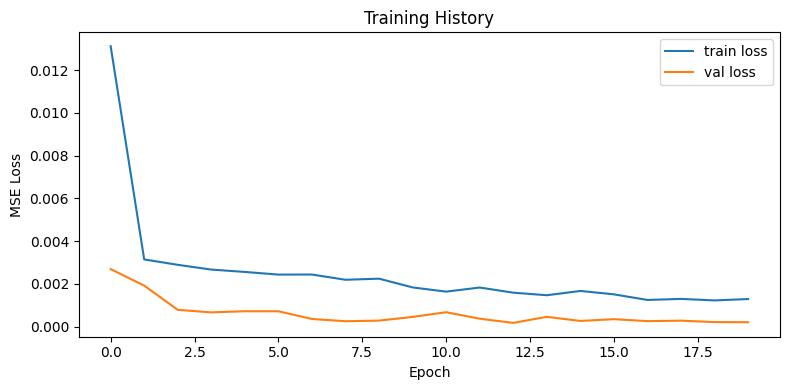

39/39 [==============================] - 0s 3ms/step


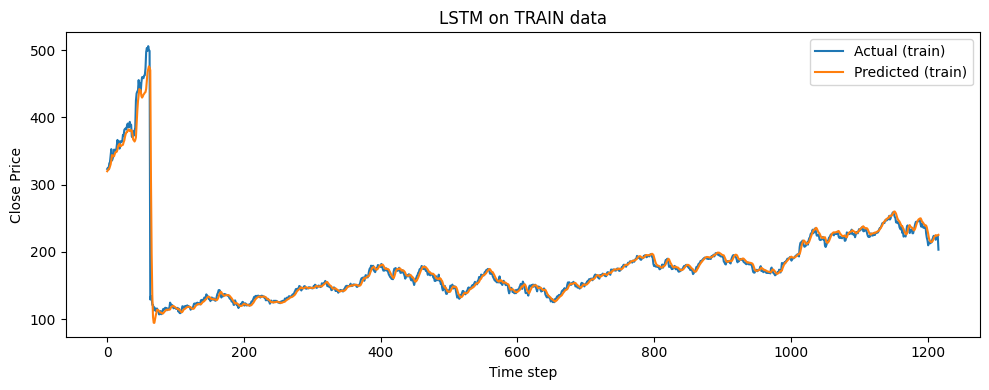

In [0]:
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Fit
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.tight_layout()
plt.show()

train_preds = model.predict(X_train).flatten()
train_actual = y_train

# plot how training is fitted 
train_preds = scaler.inverse_transform(train_preds.reshape(-1,1)).flatten()
train_actual = scaler.inverse_transform(train_actual.reshape(-1,1)).flatten()

plt.figure(figsize=(10,4))
plt.plot(train_actual,    label='Actual (train)')
plt.plot(train_preds,    label='Predicted (train)')
plt.title('LSTM on TRAIN data')
plt.xlabel('Time step')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step
LSTM Batch RMSE = 6.8136
LSTM Batch Relative RMSE = 0.0331


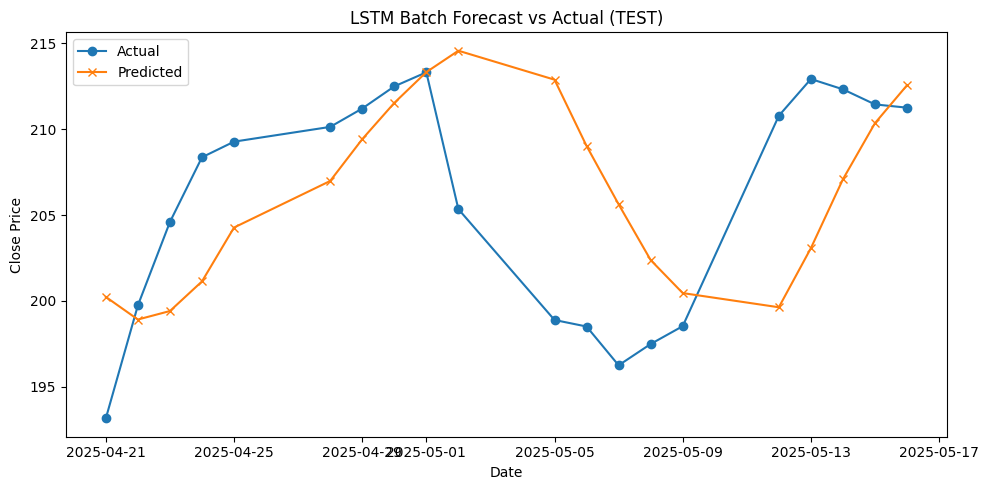

In [0]:
preds_scaled = model.predict(X_test).flatten()
preds = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# Align dates (first valid prediction is at index window_size)
dates = test_pdf["date"].dt.date.values[window_size:]

results = pd.DataFrame({"date":dates, "actual":actual, "prediction": preds})

# Metrics
rmse = np.sqrt(mean_squared_error(results["actual"], results["prediction"]))
rrmse = rmse / results["actual"].mean()
print(f"LSTM Batch RMSE = {rmse:.4f}")
print(f"LSTM Batch Relative RMSE = {rrmse:.4f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(results["date"], results["actual"],marker='o',label="Actual")
plt.plot(results["date"], results["prediction"],marker='x', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM Batch Forecast vs Actual (TEST)")
plt.legend()
plt.tight_layout()
plt.show()


The LSTM model accurately captures the underlying trends on both the training and unseen test sets. It achieves the lowest RMSE of all models, demonstrating predictions that are closest to the actual values. Its ability to learn from past errors during training and maintain stability during forecasting makes the LSTM our preferred choice for the final prediction.
